In [222]:
import lalsimulation as ls
import lal
import numpy as np

import matplotlib.pyplot as plt

import math
import time
from scipy.optimize import minimize


In [223]:
M = 100.*lal.MSUN_SI
chi1_x, chi1_y, chi2_x, chi2_y = 0.,0.,0.,0.
deltaF, f_low, f_max = 1./32., 20., 2048.
iota, phi_c, kappa = 0. , 0., 0.
phiRef = 0.
distance = 1e6*lal.PC_SI
fRef_in = f_low
q = 2.1
chi1_z = 0.
chi2_z = 0.
m1, m2 = q*M/(1.+q), M/(1.+q)

freq_range = np.linspace(0, f_max, int(f_max/deltaF))

theta, phi, psi = np.pi/3, np.pi/3, np.pi/3

Fplus =((1+np.cos(theta)**2)/2)*np.cos(2*phi)*np.cos(2*psi) - np.cos(theta)*np.sin(2*phi)*np.sin(2*psi)
Fcross =((1+np.cos(theta)**2)/2)*np.cos(2*phi)*np.sin(2*psi) + np.cos(theta)*np.sin(2*phi)*np.cos(2*psi)

kappa = -1j* np.log((Fplus + 1j*Fcross) / (np.sqrt(Fplus**2 + Fcross**2)))


In [224]:
def compute_LAL_modes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, distance, approximant):
    
    # These have to be set to 0 by definition
    inc, phiC  = 0., 0.
    
    # Generate the modes hlm 
    hlms = ls.SimInspiralChooseFDModes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, f_low, phiC, distance, inc, None, approximant)
    
    return hlms    

In [225]:
def match_HM_k_opt_LAL(hlm1_FD,hlm2_FD,iota,phi,kappa,deltaF, Sn, zpfact=2):
    # Check if the two waveform have the same size
    assert(len(hlm1_FD.fdata.data) == len(hlm1_FD.fdata.data))

    wf1_FD = compute_hFDNR_LAL(hlm1_FD,iota, phi, kappa)[:-1]

    # Compute the norm of the true waveform
    norm1 = np.sqrt(np.sum(np.abs(wf1_FD)**2/Sn))
    

    # Define the match as a function of phi. This match is analytically optimized over kappa
    def match_HM_phi_kopt(x):
        try:
            # Unpacking for multiD mimimization
            len(x)
            x = x[0]
        except:
            pass
        
        hp_ROM, hc_ROM = ls.SimInspiralPolarizationsFromSphHarmFrequencySeries(hlm2_FD,iota,x)
        hp_ROM, hc_ROM = hp_ROM.data.data[:-1], hc_ROM.data.data[:-1]
        n = len(hp_ROM)
        A_p = np.sqrt(np.sum(np.abs(hp_ROM)**2/Sn))
        A_c = np.sqrt(np.sum(np.abs(hc_ROM)**2/Sn))

        if A_c/A_p>1e-8: #if we really have two non zero polarizations
            Ipc = np.real(np.dot(np.conjugate(hp_ROM),hc_ROM/Sn))
            integrand = np.conjugate(hp_ROM)*wf1_FD/Sn
            rho_p = n*zpfact*np.real(np.fft.ifft(integrand,n=n*zpfact))
            integrand = np.conjugate(hc_ROM)*wf1_FD/Sn
            rho_c = n*zpfact*np.real(np.fft.ifft(integrand,n=n*zpfact))

            alpha = np.sqrt(rho_p**2 + rho_c**2) # this is a time series
            kappa0 = np.angle(rho_p+1.j*rho_c) # this is a time series

            gamma = np.sqrt(((A_p**2-A_c**2)/2.)**2+Ipc**2)
            sigma0 = np.angle((A_p**2-A_c**2)/2.+1.j*Ipc)
            beta = (A_p**2+A_c**2)/2.

            #print A_p,A_c,Ipc,gamma,sigma0,beta
            num = np.max(alpha*np.sqrt(beta-gamma*np.cos(2*kappa0-sigma0)))
            den = norm1*np.sqrt(beta**2-gamma**2)
            overlap = num/den
        else:
            integrand = np.conjugate(hp_ROM)*wf1_FD/Sn
            ifftterm = n*zpfact*np.fft.ifft(integrand,n=n*zpfact)
            maxifftterm = np.max([np.max(np.real(ifftterm)),np.max(-np.real(ifftterm))])
            overlap = maxifftterm/(norm1*A_p)

        return -overlap

    # Numerically optimize over phi
    # First find the minimum in a discrete manner
    phi_ini_guess = np.linspace(0.,2*np.pi,num=40)
    discrete_phi_min_index = np.argmin(np.array([match_HM_phi_kopt(phi_val) for phi_val in phi_ini_guess]))
    discrete_phi_min = phi_ini_guess[discrete_phi_min_index]
    res =minimize(match_HM_phi_kopt,x0=[discrete_phi_min,], method='Nelder-Mead')
    return -match_HM_phi_kopt(res.x)


def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)


In [226]:
def get_hyb_dummy(hlm_dummy, hlm_1, hlm_2, lam):
    if (lam > 1. or lam < 0):
        raise Exception('lambda should be between 0.0 and 1.0. The value of lambda was: {}'.format(lam))
        
    a1 = np.abs(hlm_1)
    phi1 = np.unwrap(np.angle(hlm_1))   
    
    a2 = np.abs(hlm_2)
    phi2 = np.unwrap(np.angle(hlm_2))

    a_hyb = a1*(1-lam) + a2*(lam)
    phi_hyb = phi1*(1-lam) + phi2*(lam)
    
    hlm_hyb =  a_hyb * np.exp(1.j * phi_hyb)
    
    # set dummy (2,2) data to Hybrid waveform
    freq_size = len(hlm_dummy.next.next.next.next.next.next.next.next.mode.data.data)
    zero_pos = np.where(hlm_dummy.fdata.data==0)[0][0]

    # Make sure the data extends to both sides of frequency space
    hlm_hyb_extended = np.zeros(freq_size, dtype=complex)
    hlm_hyb_extended[:zero_pos+1] = 0

    hlm_hyb_extended[zero_pos:] = hlm_hyb

    hlm_dummy.next.next.next.next.next.next.next.next.mode.data.data = hlm_hyb_extended
    
    return hlm_dummy

In [227]:
def get_LIGO_psd(f_low,deltaF,len_wf):

    # Define the frequency series where to put the PSD
    epoch = lal.LIGOTimeGPS(0, 0)

    Sn = lal.CreateREAL8FrequencySeries("psd",epoch,0.,deltaF,lal.StrainUnit,len_wf)

    # Compute the PSD from the given f_low
    ls.SimNoisePSDaLIGOZeroDetHighPowerGWINC(Sn,f_low)
    
    Sn.data.data[0 : int(f_low/deltaF)] = Sn.data.data[int(f_low/deltaF)]
    Sn.data.data[-1] = Sn.data.data[-2]
    
    return Sn

In [228]:
def compute_hFDNR_LAL(hlm_FD,theta,phi,kappa):
    hpFD,hcFD = ls.SimInspiralPolarizationsFromSphHarmFrequencySeries(hlm_FD,theta,np.pi/2.-phi)
    return np.cos(kappa)*hpFD.data.data+np.sin(kappa)*hcFD.data.data

In [229]:
Sn = get_LIGO_psd(f_low,deltaF,int(f_max/deltaF))

## Generate Waveforms

In [230]:
approximant = ls.IMRPhenomXAS
hplus , hcross  = ls.SimInspiralChooseFDWaveform(m1=m1, m2=m2, S1x=chi1_x, S1y=chi1_y, S1z=chi1_z, S2x=chi2_x, S2y=chi2_y, S2z=chi2_z, distance=distance, inclination=iota, phiRef=phiRef, longAscNodes=0., eccentricity=0., meanPerAno=0., deltaF=deltaF, f_min=f_low, f_max=f_max, f_ref=fRef_in, LALpars=None, approximant=approximant)
hlm_xas = hplus.data.data[:-1] + 1.j*hcross.data.data[:-1]

approximant = ls.IMRPhenomD
hplus , hcross  = ls.SimInspiralChooseFDWaveform(m1=m1, m2=m2, S1x=chi1_x, S1y=chi1_y, S1z=chi1_z, S2x=chi2_x, S2y=chi2_y, S2z=chi2_z, distance=distance, inclination=iota, phiRef=phiRef, longAscNodes=0., eccentricity=0., meanPerAno=0., deltaF=deltaF, f_min=f_low, f_max=f_max, f_ref=fRef_in, LALpars=None, approximant=approximant)
hlm_d = hplus.data.data[:-1] + 1.j*hcross.data.data[:-1]
hlm_d = -hlm_d

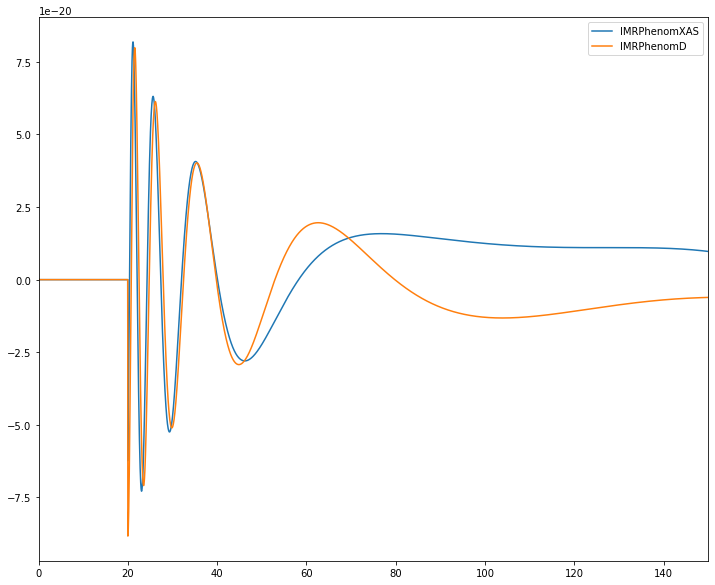

In [231]:
f, (ax)= plt.subplots(1, 1,  figsize=(12,10)) 
plt.plot(freq_range, np.real(hlm_xas), label='IMRPhenomXAS')
plt.plot(freq_range, np.real(hlm_d), label='IMRPhenomD')
plt.xlim (0, 150)
plt.legend()
plt.show()

# Optimize $\Delta \phi$

Let's express the two waveforms using following decompositions:
$$ h^{(1)}_{lm}(f) = A^{(1)}_{lm}(f) \exp[{i \phi^{(1)}_{lm}(f)}]$$
$$ h^{(2)}_{lm}(f) = A^{(2)}_{lm}(f) \exp[{i \phi^{(2)}_{lm}(f)}]$$

We want to minimize the initial time difference, which can be expressed as a frequency-dependent phase factor $ \exp[{i (\Delta\phi)}] = \exp[{i ( \phi_a + \phi_b f)}] $

Therefore, our task is to find a phase offset $\Delta \phi$ that minimizes the integrated phase difference 
$$ \int_{f_{min}}^{f_{max}}  \phi^{(1)}(f) -  (\phi^{(2)}(f) + \Delta \phi) \;\; df $$
$$ = \int_{f_{min}}^{f_{max}}  \phi^{(1)}(f) -  \phi^{(2)}(f) -  \phi_a - (\phi_b \cdot f) \;\; df $$

In [241]:
a1 = np.abs(hlm_xas)
phi1 = np.unwrap(np.angle(hlm_xas))   

a2 = np.abs(hlm_d)
phi2 = np.unwrap(np.angle(hlm_d))

# Integral (over low frequency domain)
f_minn = 20.
f_maxx = 30.

In [242]:
def integral(phis, args):
    phi_a, phi_b = phis[0], phis[1]

    phi1, phi2, f_min, f_max = args[0], args[1], args[2], args[3]

    index_min = np.where(freq_range>f_min)[0][0]
    index_max = np.where(freq_range>f_max)[0][0]
    phase_diff = np.sum(phi1[index_min:index_max] - phi2[index_min:index_max])

    return  np.abs(phase_diff - (phi_a*(f_max - f_min)) - (phi_b * (((f_max**2) /2) - ((f_min**2) /2))))

initial_guess = [21.4, 1.]

args = [phi1, phi2, f_minn, f_maxx]
result = minimize(integral, initial_guess, args=args, method='Nelder-Mead')

phi_a_opt, phi_b_opt = result.x[0], result.x[1]
print(f"f_max = {f_maxx}, phi_a: {phi_a_opt:.3f}, phi_b: {phi_b_opt:.3f}, min: {result.fun}")


f_max = 30.0, phi_a: 26.167, phi_b: -0.319, min: 0.0


## Construct 'optimized' IMRPhenomD waveform

In [243]:
delta_phi = phi_a_opt + (phi_b_opt*freq_range)
hlm_d_opt = a2 * np.exp(1.j * (phi2 + delta_phi ))

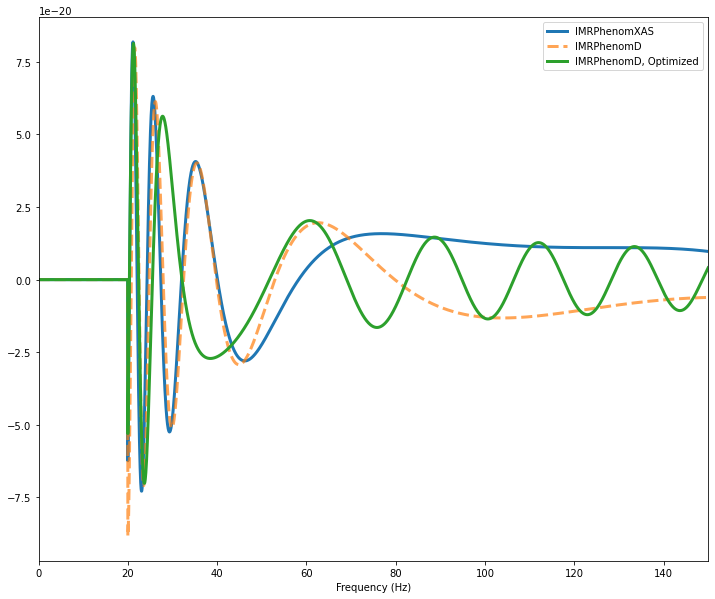

In [244]:
f, (ax)= plt.subplots(1, 1,  figsize=(12,10)) 
plt.plot(freq_range, np.real(hlm_xas), lw=3, label='IMRPhenomXAS')
plt.plot(freq_range, np.real(hlm_d), lw=3, linestyle='--', label='IMRPhenomD', alpha=0.7)
plt.plot(freq_range, np.real(hlm_d_opt), lw=3, label='IMRPhenomD, Optimized')
plt.xlim (0, 150)
plt.xlabel("Frequency (Hz)")
plt.legend()
plt.show()

## Constant $\Delta \phi$ implementation test

In [209]:
def integral_1d(phi_a, args):

    phi1, phi2, f_min, f_max = args[0], args[1], args[2], args[3]

    index_min = np.where(freq_range>f_min)[0][0]
    index_max = np.where(freq_range>f_max)[0][0]
    phase_diff = np.sum(phi1[index_min:index_max] - phi2[index_min:index_max])

    return  np.abs(phase_diff - (phi_a*(f_max - f_min)))

initial_guess = [21.4]
args = [phi1, phi2, f_minn, f_maxx]
result_1d = minimize(integral_1d, initial_guess, args=args, method='Nelder-Mead')

In [210]:
print(result_1d.x)
print(integral_1d(result_1d.x, args))

[-22.10427938]
[7.13989086e-05]


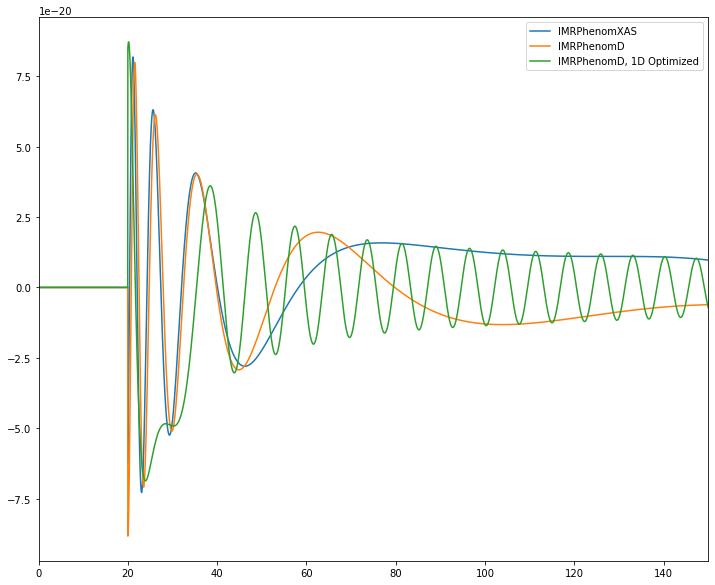

In [211]:
delta_phi_1d = result_1d.x[0]
hlm_d_opt_1d = a2 * np.exp(1.j * (phi2 + delta_phi))

f, (ax)= plt.subplots(1, 1,  figsize=(12,10)) 
plt.plot(freq_range, np.real(hlm_xas), label='IMRPhenomXAS')
plt.plot(freq_range, np.real(hlm_d), label='IMRPhenomD')
plt.plot(freq_range, np.real(hlm_d_opt_1d), label='IMRPhenomD, 1D Optimized')
plt.xlim (0, 150)
plt.legend()
plt.show()

# Compute Faithfulness for Hybrid Waveforms

## Generate SphHarmFrequencySeries versions of the waveforms

In [212]:
def phase_diff_integral(phis, args):
    phi_a, phi_b = phis[0], phis[1]

    phi1, phi2, f_min, f_max, freq_range = args[0], args[1], args[2], args[3], args[4]

    index_min = np.where(freq_range>f_min)[0][0]
    index_max = np.where(freq_range>f_max)[0][0]
    phase_diff = np.sum(phi1[index_min:index_max] - phi2[index_min:index_max])

    return  np.abs(phase_diff - (phi_a*(f_max - f_min)) - (phi_b * (((f_max**2) /2) - ((f_min**2) /2))))

In [213]:
hlm_dummy_xas = compute_LAL_modes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, distance, approximant = ls.IMRPhenomHM)
hlm_dummy_d = compute_LAL_modes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, distance, approximant = ls.IMRPhenomHM)

print(type(hlm_dummy_d))

freq_size = len(hlm_dummy_xas.next.next.next.next.next.next.next.next.mode.data.data)
freq_range_dummy = hlm_dummy_xas.next.next.next.next.next.next.next.next.fdata.data
zero_pos = np.where(hlm_dummy_xas.fdata.data==0)[0][0]


<class 'lalsimulation.SphHarmFrequencySeries'>


In [214]:
# IMRPhenomXAS
approximant = ls.IMRPhenomXAS
hplus, hcross = ls.SimInspiralChooseFDWaveform(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, distance, phi_c, phiRef, 0., 0., 0., deltaF, f_low, f_max, fRef_in, None, approximant=approximant)
hlm_xas = hplus.data.data + 1j*hcross.data.data

# set dummy (2,2) data to IMRPhenomD waveform
l = hlm_dummy_xas.next.next.next.next.next.next.next.next.l
m = hlm_dummy_xas.next.next.next.next.next.next.next.next.m
print(f"overwriting ({l}, {m}) mode")

freq_size = len(hlm_dummy_xas.next.next.next.next.next.next.next.next.mode.data.data)
zero_pos = np.where(hlm_dummy_xas.fdata.data==0)[0][0]

hlm_xas_extended = np.zeros(freq_size, dtype=complex)
hlm_xas_extended[:zero_pos+1] = 0

hlm_xas_extended[zero_pos:] = hlm_xas

hlm_dummy_xas.next.next.next.next.next.next.next.next.mode.data.data = hlm_xas_extended


overwriting (2, 2) mode


In [215]:
# IMRPhenomD
approximant = ls.IMRPhenomD
hplus, hcross = ls.SimInspiralChooseFDWaveform(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, distance, phi_c, phiRef, 0., 0., 0., deltaF, f_low, f_max, fRef_in, None, approximant=approximant)
hlm_d = hplus.data.data + 1j*hcross.data.data
hlm_d = -hlm_d # Flipped to account for convention

# Replace IMRPhenomD extended waveform with optimized version
a1 = np.abs(hlm_xas)
phi1 = np.unwrap(np.angle(hlm_xas))  

a2 = np.abs(hlm_d)
phi2 = np.unwrap(np.angle(hlm_d))

f_minn = 20.
f_maxx = 40.

initial_guess = [21.4, 1.]
args = [phi1, phi2, f_minn, f_maxx, freq_range]
result = minimize(phase_diff_integral, initial_guess, args=args, method='Nelder-Mead')
print(result.x, result.fun)

phi_a_opt, phi_b_opt = result.x[0], result.x[1]
delta_phi = np.zeros(len(hlm_xas))
delta_phi[:-1] = phi_a_opt + (phi_b_opt*freq_range)
hlm_d = a2 * np.exp(1.j * (phi2 + delta_phi ))

# set dummy (2,2) data to IMRPhenomD waveform
l = hlm_dummy_d.next.next.next.next.next.next.next.next.l
m = hlm_dummy_d.next.next.next.next.next.next.next.next.m
print(f"overwriting ({l}, {m}) mode")

freq_size = len(hlm_dummy_d.next.next.next.next.next.next.next.next.mode.data.data)
zero_pos = np.where(hlm_dummy_d.fdata.data==0)[0][0]

hlm_d_extended = np.zeros(freq_size, dtype=complex)
hlm_d_extended[:zero_pos+1] = 0
hlm_d_extended[zero_pos:] = hlm_d

hlm_dummy_d.next.next.next.next.next.next.next.next.mode.data.data = hlm_d_extended


[28.00275388 -0.56062097] 1.1368683772161603e-13
overwriting (2, 2) mode


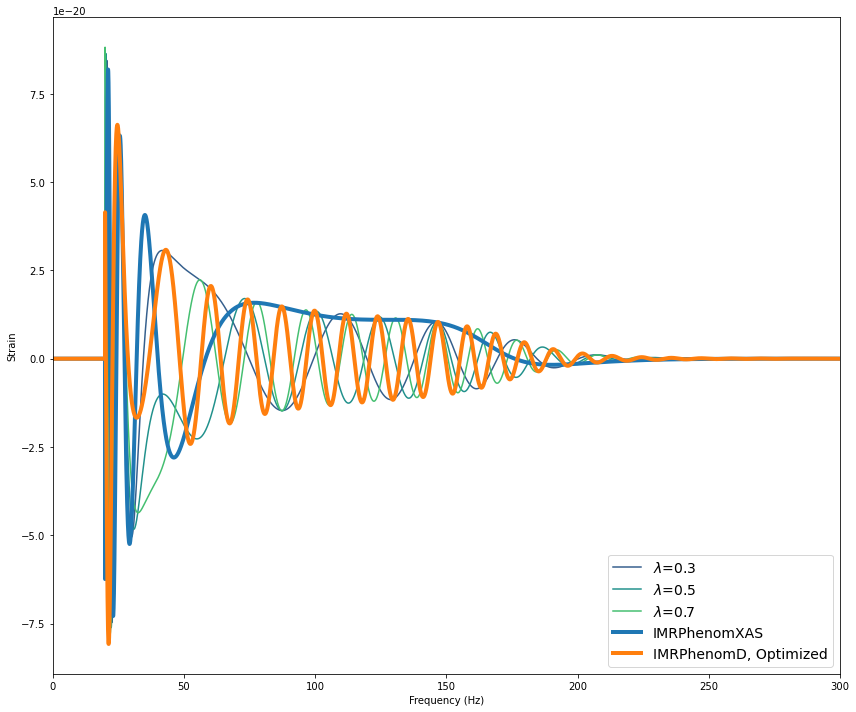

In [216]:
# confirm that the Hybrid Waveforms work as expected

f, (ax)= plt.subplots(1, 1,  figsize=(12,10)) 
lw=4


lams = np.linspace(0.3, 0.7, 3)
colors = plt.cm.viridis(lams)


for i in range(len(lams)):
    hlm_dummy_test = compute_LAL_modes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, distance, approximant=ls.IMRPhenomHM);
    hlm_dummy_hybrid = get_hyb_dummy(hlm_dummy_test, hlm_xas, hlm_d, lams[i]);
    ax.plot(hlm_dummy_hybrid.fdata.data, np.real(hlm_dummy_hybrid.next.next.next.next.next.next.next.next.mode.data.data), color=colors[i], label=f'$\lambda$={lams[i]:.1f}')
    

ax.plot(hlm_dummy_hybrid.fdata.data, np.real(hlm_xas_extended), lw=lw, label="IMRPhenomXAS")

hlm_dummy_test = compute_LAL_modes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, distance, approximant=ls.IMRPhenomHM);
hlm_dummy_d = get_hyb_dummy(hlm_dummy_test, hlm_xas, hlm_d, 1.0);

ax.plot(hlm_dummy_d.fdata.data, np.real(hlm_d_extended), lw=lw, label="IMRPhenomD, Optimized")
ax.set_xlim(0, 300)
ax.legend(fontsize=14, loc='lower right')
ax.set_ylabel('Strain')
ax.set_xlabel('Frequency (Hz)')

plt.tight_layout()
plt.show();

## Compute Faithfulness

In [158]:
lam = 0.0

hlm_dummy_test = compute_LAL_modes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, distance, approximant=ls.IMRPhenomHM)
hlm_hyb_test = get_hyb_dummy(hlm_dummy_test, hlm_xas, hlm_d, lam)

match = match_HM_k_opt_LAL(hlm_dummy_xas, hlm_hyb_test, iota, phi_c, kappa ,deltaF, Sn.data.data, zpfact=8)
print(f"Match to IMRPhenomXAS for lambda={lam} : {match:.3f}")


Match to IMRPhenomXAS for lambda=0.0 : 1.000


In [159]:
start = time.time()
lam = 1.0

hlm_dummy_test = compute_LAL_modes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, distance, approximant=ls.IMRPhenomHM)
hlm_hyb_test = get_hyb_dummy(hlm_dummy_test, hlm_xas, hlm_d, lam)

match = match_HM_k_opt_LAL(hlm_dummy_xas, hlm_hyb_test, iota, phi_c, kappa ,deltaF, Sn.data.data, zpfact=8)
print(f"Match to IMRPhenomXAS for lambda={lam} : {match:.3f}")

end = time.time()
print(f"Calculation completed in {end-start:.2f} s")


Match to IMRPhenomXAS for lambda=1.0 : 0.996
Calculation completed in 4.49 s


In [160]:
n_lams = 10

lams = np.linspace(0.0, 1.0, n_lams)
matches = np.zeros(n_lams)

for i in range(0, n_lams):
    hlm_dummy_test = compute_LAL_modes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, distance, approximant=ls.IMRPhenomHM)
    hlm_hyb_test = get_hyb_dummy(hlm_dummy_test, hlm_xas, hlm_d, lams[i])

    matches[i] = match_HM_k_opt_LAL(hlm_dummy_xas, hlm_hyb_test, iota, phi_c, kappa ,deltaF, Sn.data.data, zpfact=8)
    

In [161]:
for i in range(0, n_lams):
    print(f"Match to IMRPhenomXAS for lambda={lams[i]:.1f} : {matches[i]:.5f}")

Match to IMRPhenomXAS for lambda=0.0 : 1.00000
Match to IMRPhenomXAS for lambda=0.1 : 0.99700
Match to IMRPhenomXAS for lambda=0.2 : 0.99674
Match to IMRPhenomXAS for lambda=0.3 : 0.99678
Match to IMRPhenomXAS for lambda=0.4 : 0.99667
Match to IMRPhenomXAS for lambda=0.6 : 0.99651
Match to IMRPhenomXAS for lambda=0.7 : 0.99640
Match to IMRPhenomXAS for lambda=0.8 : 0.99617
Match to IMRPhenomXAS for lambda=0.9 : 0.99605
Match to IMRPhenomXAS for lambda=1.0 : 0.99577


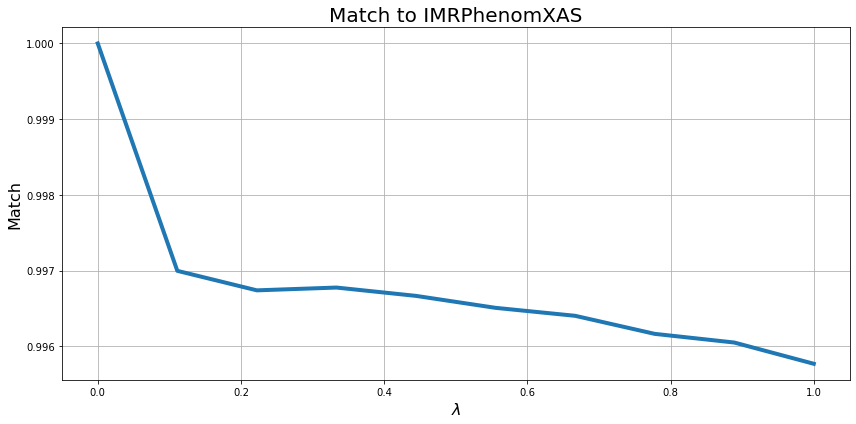

In [162]:
f, (ax)= plt.subplots(1, 1,  figsize=(12,6)) 

lw=4
plt.plot(lams, matches, lw=lw)

plt.ylabel('Match', fontsize=16)
plt.xlabel('$\lambda$', fontsize=16)

plt.title('Match to IMRPhenomXAS', fontsize=20)
plt.grid()
plt.tight_layout()
plt.show()

# Determine Frequency Range required to keep Faithfulness Monotonic

In [143]:
# Fixed Parameters

chi1_x, chi1_y, chi2_x, chi2_y = 0.,0.,0.,0.
deltaF, f_low, f_max = 1./32., 20., 2048.
iota, phi_c, kappa = 0. , 0., 0.
phiRef = 0.
distance = 1e6*lal.PC_SI
fRef_in = f_low

chi1_z = 0.
chi2_z = 0.


freq_range = np.linspace(0, f_max, int(f_max/deltaF))

theta, phi, psi = np.pi/3, np.pi/3, np.pi/3

Fplus =((1+np.cos(theta)**2)/2)*np.cos(2*phi)*np.cos(2*psi) - np.cos(theta)*np.sin(2*phi)*np.sin(2*psi)
Fcross =((1+np.cos(theta)**2)/2)*np.cos(2*phi)*np.sin(2*psi) + np.cos(theta)*np.sin(2*phi)*np.cos(2*psi)

kappa = -1j* np.log((Fplus + 1j*Fcross) / (np.sqrt(Fplus**2 + Fcross**2)))


In [144]:
def phase_diff_integral(phis, args):
    phi_a, phi_b = phis[0], phis[1]

    phi1, phi2, f_min, f_max, freq_range = args[0], args[1], args[2], args[3], args[4]

    index_min = np.where(freq_range>f_min)[0][0]
    index_max = np.where(freq_range>f_max)[0][0]
    phase_diff = np.sum(phi1[index_min:index_max] - phi2[index_min:index_max])

    return  np.abs(phase_diff - (phi_a*(f_max - f_min)) - (phi_b * (((f_max**2) /2) - ((f_min**2) /2))))

In [176]:
def get_all_waveforms(m1, m2, f_minn, f_maxx):
    
    
    hlm_dummy_xas = compute_LAL_modes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, distance, approximant = ls.IMRPhenomHM)
    hlm_dummy_d = compute_LAL_modes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, distance, approximant = ls.IMRPhenomHM)

    freq_size = len(hlm_dummy_xas.next.next.next.next.next.next.next.next.mode.data.data)
    freq_range_dummy = hlm_dummy_xas.next.next.next.next.next.next.next.next.fdata.data
    zero_pos = np.where(hlm_dummy_xas.fdata.data==0)[0][0]

    # IMRPhenomXAS
    approximant = ls.IMRPhenomXAS
    hplus, hcross = ls.SimInspiralChooseFDWaveform(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, distance, phi_c, phiRef, 0., 0., 0., deltaF, f_low, f_max, fRef_in, None, approximant=approximant)
    hlm_xas = hplus.data.data + 1j*hcross.data.data

    # set dummy (2,2) data to IMRPhenomD waveform
    l = hlm_dummy_xas.next.next.next.next.next.next.next.next.l
    m = hlm_dummy_xas.next.next.next.next.next.next.next.next.m

    freq_size = len(hlm_dummy_xas.next.next.next.next.next.next.next.next.mode.data.data)
    zero_pos = np.where(hlm_dummy_xas.fdata.data==0)[0][0]

    hlm_xas_extended = np.zeros(freq_size, dtype=complex)
    hlm_xas_extended[:zero_pos+1] = 0

    hlm_xas_extended[zero_pos:] = hlm_xas

    hlm_dummy_xas.next.next.next.next.next.next.next.next.mode.data.data = hlm_xas_extended


    # IMRPhenomD
    approximant = ls.IMRPhenomD
    hplus, hcross = ls.SimInspiralChooseFDWaveform(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, distance, phi_c, phiRef, 0., 0., 0., deltaF, f_low, f_max, fRef_in, None, approximant=approximant)
    hlm_d = hplus.data.data + 1j*hcross.data.data
    hlm_d = -hlm_d # Flipped to account for convention

    # Replace IMRPhenomD extended waveform with optimized version
    a1 = np.abs(hlm_xas)
    phi1 = np.unwrap(np.angle(hlm_xas))  

    a2 = np.abs(hlm_d)
    phi2 = np.unwrap(np.angle(hlm_d))


    initial_guess = [21.4, 1.]
    args = [phi1, phi2, f_minn, f_maxx, freq_range]
    result = minimize(phase_diff_integral, initial_guess, args=args, method='Nelder-Mead')

    phi_a_opt, phi_b_opt = result.x[0], result.x[1]
    delta_phi = np.zeros(len(hlm_xas))
    delta_phi[1:] = phi_a_opt + (phi_b_opt*freq_range)
    hlm_d = a2 * np.exp(1.j * (phi2 + delta_phi ))


    return hlm_dummy_xas, hlm_xas, hlm_d


## Compute Faithfulness

In [177]:
M = 50.*lal.MSUN_SI
q = 2.1
m1, m2 = q*M/(1.+q), M/(1.+q)

f_minn = 20.
f_maxx = 30.
hlm_dummy_xas, hlm_xas, hlm_d = get_all_waveforms(m1, m2, f_minn, f_maxx)

In [178]:
start = time.time()
lam = 0.

hlm_dummy_test = compute_LAL_modes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, distance, approximant=ls.IMRPhenomHM)
hlm_hyb_test = get_hyb_dummy(hlm_dummy_test, hlm_xas, hlm_d, lam)

match = match_HM_k_opt_LAL(hlm_dummy_xas, hlm_hyb_test, iota, phi_c, kappa ,deltaF, Sn.data.data, zpfact=8)
print(f"Match to IMRPhenomXAS for lambda={lam} : {match:.3f}")

end = time.time()
print(f"Calculation completed in {end-start:.2f} s")


Match to IMRPhenomXAS for lambda=0.0 : 1.000
Calculation completed in 3.25 s


In [191]:
n_lams = 10
lams = np.linspace(0.0, 1.0, n_lams)

n_Ms = 5
Ms = np.linspace(10, 100, n_Ms)*lal.MSUN_SI
q = 2.1

f_maxx_range = np.linspace(50., 90, 9)
f_maxx_range = f_maxx_range[::-1]

min_freqs_high = np.zeros(n_Ms)

faiths_for_config = np.zeros(n_lams)

for i in range(0, n_Ms):
    M_tot = Ms[i]
    print(f"M_tot = {M_tot/lal.MSUN_SI}")
    m1, m2 = q*M_tot/(1.+q), M_tot/(1.+q)
    f_maxx_lim_found = False

    for j, f_maxx in enumerate(f_maxx_range):
        if (not f_maxx_lim_found):
            print(f"Trying f_maxx = {f_maxx:.2f}")
            hlm_dummy_xas, hlm_xas, hlm_d = get_all_waveforms(m1, m2, f_minn, f_maxx)
            
            hlm_dummy_test = compute_LAL_modes(m1, m2, chi1_x, chi1_y, chi1_z, chi2_x, chi2_y, chi2_z, deltaF, f_low, f_max, distance, approximant=ls.IMRPhenomHM)

            for k in range(0, n_lams):
                hlm_hyb_test = get_hyb_dummy(hlm_dummy_test, hlm_xas, hlm_d, lams[k])
                faiths_for_config[k] = match_HM_k_opt_LAL(hlm_dummy_xas, hlm_hyb_test, iota, phi_c, kappa ,deltaF, Sn.data.data, zpfact=8)

                if (j>0 and k>0 and faiths_for_config[k]>faiths_for_config[k-1]):
                    print(f"f_maxx = {f_maxx:.2f} is not monotonic")
                    min_freqs_high[i] = f_maxx_range[j-1]
                    f_maxx_lim_found = True
                    print(f"Minimum f_maxx needed for M_tot = {M_tot/lal.MSUN_SI} is {min_freqs_high[i]:.2f} Hz ")
                    print()
                    break


M_tot = 10.0
Trying f_maxx = 90.00
Trying f_maxx = 85.00
f_maxx = 85.00 is not monotonic
Minimum f_maxx needed for M_tot = 10.0 is 90.00 Hz 

M_tot = 32.5
Trying f_maxx = 90.00
Trying f_maxx = 85.00
f_maxx = 85.00 is not monotonic
Minimum f_maxx needed for M_tot = 32.5 is 90.00 Hz 

M_tot = 55.0
Trying f_maxx = 90.00
Trying f_maxx = 85.00
Trying f_maxx = 80.00
Trying f_maxx = 75.00
Trying f_maxx = 70.00
Trying f_maxx = 65.00
Trying f_maxx = 60.00
Trying f_maxx = 55.00
f_maxx = 55.00 is not monotonic
Minimum f_maxx needed for M_tot = 55.0 is 60.00 Hz 

M_tot = 77.5
Trying f_maxx = 90.00
Trying f_maxx = 85.00
Trying f_maxx = 80.00
Trying f_maxx = 75.00
Trying f_maxx = 70.00
f_maxx = 70.00 is not monotonic
Minimum f_maxx needed for M_tot = 77.5 is 75.00 Hz 

M_tot = 100.0
Trying f_maxx = 90.00
Trying f_maxx = 85.00
Trying f_maxx = 80.00
Trying f_maxx = 75.00
Trying f_maxx = 70.00
Trying f_maxx = 65.00
Trying f_maxx = 60.00
f_maxx = 60.00 is not monotonic
Minimum f_maxx needed for M_tot = 

In [194]:
for i in range(0, n_Ms):
    print(f"Minimum f_max for M_tot = {Ms[i]/lal.MSUN_SI}, q={q:.1f} : {min_freqs_high[i]:.2f} Hz")

Minimum f_max for M_tot = 10.0, q=2.1 : 90.00 Hz
Minimum f_max for M_tot = 32.5, q=2.1 : 90.00 Hz
Minimum f_max for M_tot = 55.0, q=2.1 : 60.00 Hz
Minimum f_max for M_tot = 77.5, q=2.1 : 75.00 Hz
Minimum f_max for M_tot = 100.0, q=2.1 : 65.00 Hz


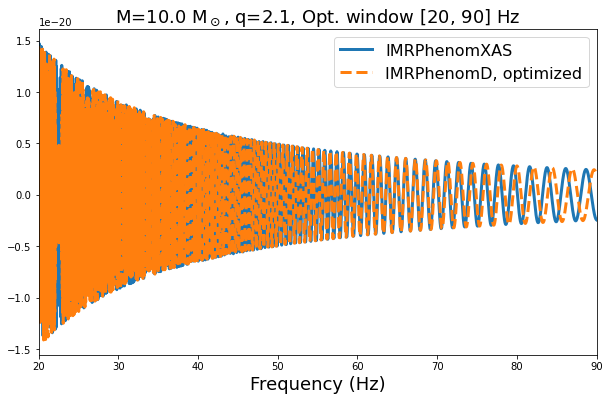

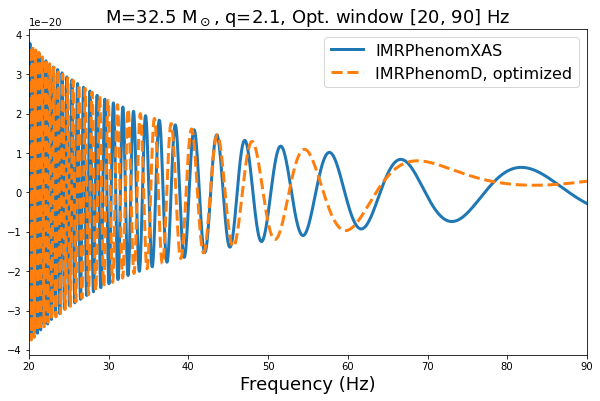

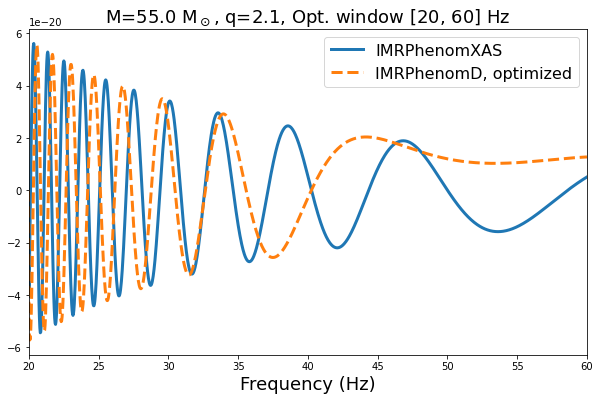

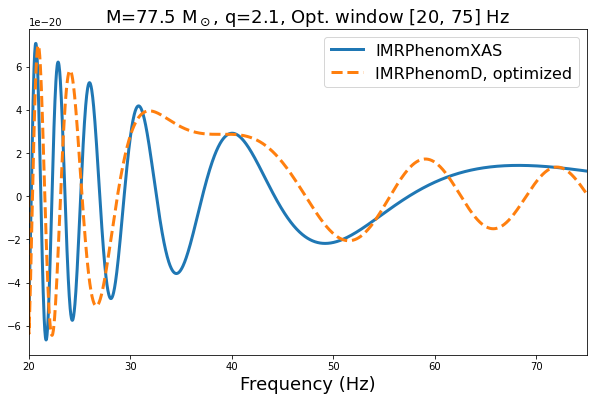

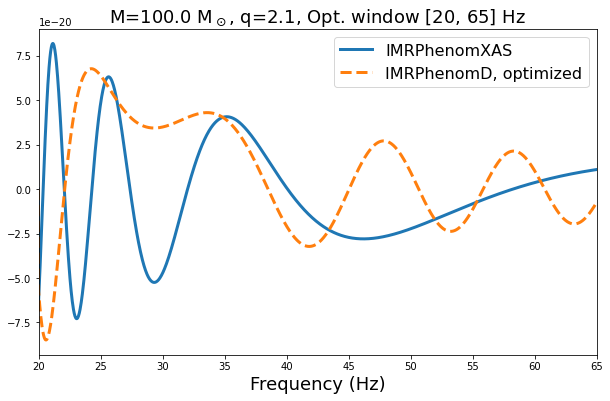

In [256]:
for i in range(n_Ms):
    M_tot = Ms[i]
    m1, m2 = q*M_tot/(1.+q), M_tot/(1.+q)

    f_maxx = min_freqs_high[i]

    hlm_dummy_xas, hlm_xas, hlm_d = get_all_waveforms(m1, m2, f_minn, f_maxx)
    
    f, (ax)= plt.subplots(1, 1,  figsize=(10,6)) 

    plt.plot(freq_range, np.real(hlm_xas[:-1]), lw=3, label='IMRPhenomXAS')
    plt.plot(freq_range, np.real(hlm_d[:-1]), lw=3, linestyle='--', label='IMRPhenomD, optimized')
    plt.title(f"M={M_tot/lal.MSUN_SI} M$_\odot$, q={q:.1f}, Opt. window [20, {f_maxx:.0f}] Hz", fontsize=18)
    plt.xlim (20, f_maxx)
    plt.xlabel("Frequency (Hz)", fontsize=18)
    plt.legend(fontsize=16)
    plt.show()
    

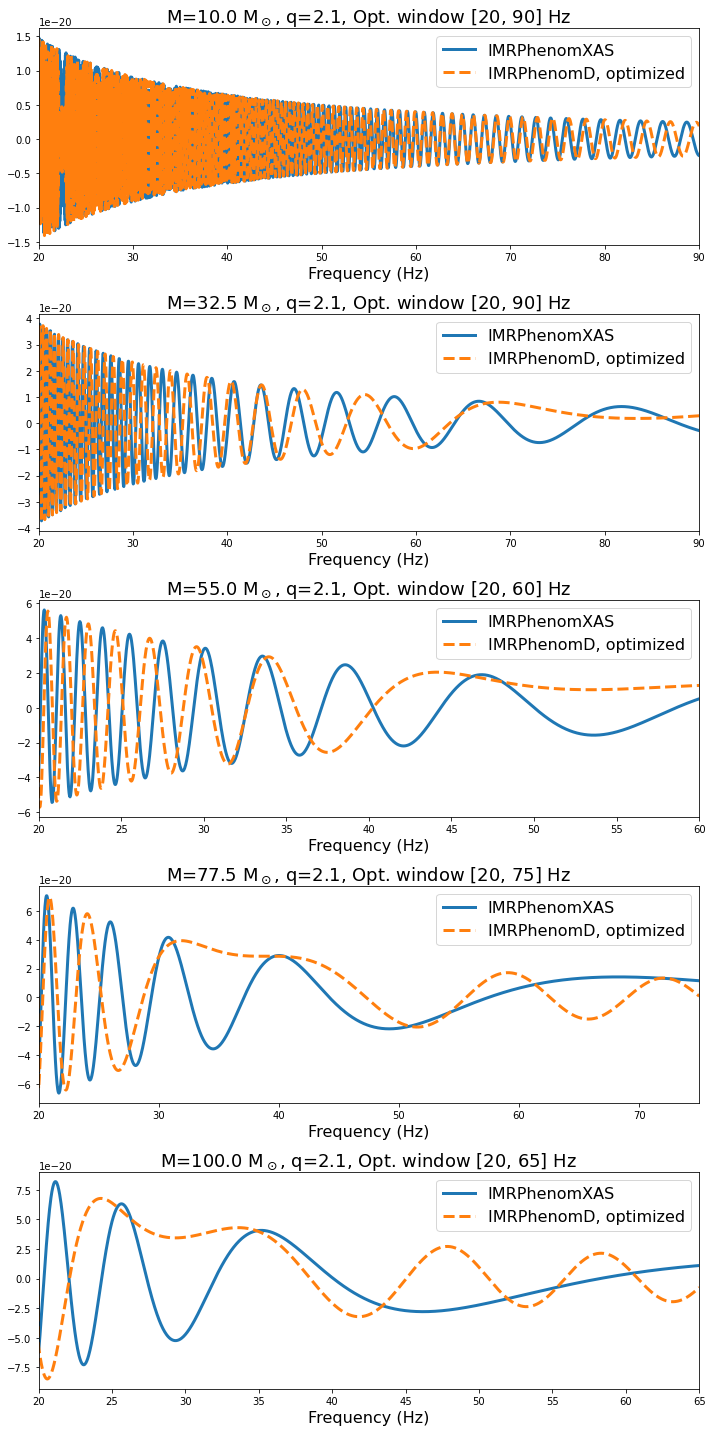

In [264]:
f, axes= plt.subplots(n_Ms, 1,  figsize=(10,20)) 

for i in range(n_Ms):    
    M_tot = Ms[i]
    m1, m2 = q*M_tot/(1.+q), M_tot/(1.+q)

    f_maxx = min_freqs_high[i]

    hlm_dummy_xas, hlm_xas, hlm_d = get_all_waveforms(m1, m2, f_minn, f_maxx)
    
    axes[i].plot(freq_range, np.real(hlm_xas[:-1]), lw=3, label='IMRPhenomXAS')
    axes[i].plot(freq_range, np.real(hlm_d[:-1]), lw=3, linestyle='--', label='IMRPhenomD, optimized')
    axes[i].set_title(f"M={M_tot/lal.MSUN_SI} M$_\odot$, q={q:.1f}, Opt. window [20, {f_maxx:.0f}] Hz", fontsize=18)
    axes[i].set_xlim (20, f_maxx)
    axes[i].set_xlabel("Frequency (Hz)", fontsize=16)
    axes[i].legend(fontsize=16)

plt.tight_layout()
plt.show()
    